# FC Classification
1. Prepare Xy
2. fit a simple SVM classifier

In [462]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.linear_model import LogisticRegressionCV
import sklearn

# useful functions
def _patch_brain():
    brain_areas = {
                    'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5', 'FT7'],
                    'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5'],
                    'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
                    'LO': ['O1', 'PO3'],
                    'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6', 'FT8'],
                    'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6'],
                    'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
                    'RO': ['O2', 'PO4'],
                    'FZ': ['Fpz', 'Fz'],
                    'CZ': ['Cz', 'CPz', 'FCz'],
                    'PZ': ['Pz', 'POz'],
                    'OZ': ['Oz', 'Iz']
        }
    return brain_areas


def _make_montage(path='data/raw/plb-hyp-live2131111.vhdr'):
    """
    Create a montage from barin vision raw data

    Parameters
    ----------
    path : str
        path to barinvision data header file

    """
    import copy
    raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
    raw.crop(1, 10)  # crop a small segment of the data to speed up data loading in next lines
    raw.load_data().set_channel_types({'ECG': 'ecg'})
    # raw.add_reference_channels('FCz')  # FCz was used as online reference
    ch_names = copy.deepcopy(raw.info['ch_names'])  # make a deep copy of the lists of the
    # channel names otherwise ecg channel will be removed in the raw object!!
    ch_names.remove('ECG')

    pos_array = raw._get_channel_positions()

    # # add FCz position based on channels CPz (Their positions are the same, only y-axis value is different)
    # pos_fcz = pos_array[ch_names.index('CPz')] * np.array([1, -1, 1])
    # pos_array = np.insert(pos_array, 60, pos_fcz, axis=0)
    # pos_array = np.delete(pos_array, -1, axis=0)

    pos_dict = dict(zip(ch_names, pos_array))
    pos = mne.channels.make_dig_montage(pos_dict)

    return pos


## Prepare Xy

In [559]:
# read data
DATA = pd.read_csv('data/conn_df_correlation.csv', index_col='Unnamed: 0')
DATA = DATA.query('description == "hypnosis"')
# DATA = DATA.iloc[100:]
# DATA = DATA[DATA['condition'].str.contains('experience')]

# temporary: save original column names
orig_columns = DATA.columns

# change column names
import mne
dir = 'data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif'
epochs = mne.read_epochs(dir, verbose=0)
epochs.pick_types(eeg=True)
ch_names = epochs.ch_names
del epochs
conn_labels = pd.DataFrame(columns=ch_names, index=ch_names)
conn_labels = conn_labels.apply(lambda x: x.index + '\N{left right arrow}' + x.name)
conn_labels = conn_labels.values[np.triu_indices(conn_labels.shape[0], k=0)]
bh_features = list(orig_columns[:6])
conn_labels = list(conn_labels)
[conn_labels.insert(0, bh_features[5-i]) for i in range(len(bh_features))]
# set new columns
DATA.columns = conn_labels

# drop self-connections
identicals_col = [f'{i}\N{left right arrow}{i}' for i in ch_names]
DATA.drop(identicals_col, axis=1, inplace=True)

# drop connections with M1 or M2
DATA.drop(DATA.columns[DATA.columns.str.contains('M1')], axis=1, inplace=True)
DATA.drop(DATA.columns[DATA.columns.str.contains('M2')], axis=1, inplace=True)

#Xy
X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition', 'bids_id'])

hypnosis_depth_median = DATA['hypnosis_depth'].median()

y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= hypnosis_depth_median  else 1)

y.value_counts(normalize=True)

# col_name = imp_df1.drop_duplicates('feature').iloc[:252, 0]
# X = X[col_name]

0    0.53
1    0.47
Name: hypnosis_depth, dtype: float64

### Feature Engineering
1. aggregate connections across different brain patches

In [563]:
# create connection labels based on brain areas
brain_areas = _patch_brain()

key_list = list(brain_areas.keys())
agg_conn = {}
for i in range(len(key_list)):
    j = i + 1
    while j < len(key_list):
        agg_conn[key_list[i] + '_' + key_list[j]] = [first + '\N{left right arrow}' + second 
                                                  for first in brain_areas[key_list[i]] 
                                                  for second in brain_areas[key_list[j]]]
        j += 1

# aggregate features based on brain areas
for key in agg_conn.keys():
    # find mismatches
    temp_l1 = [i for i in agg_conn[key] if i not in DATA.columns]
    
    # flip mismatches, if there are any
    if len(temp_l1) > 0:
        temp_l2 = [
            temp_l1[i].split('\N{left right arrow}')[1] + 
            '\N{left right arrow}' + 
            temp_l1[i].split('\N{left right arrow}')[0]
        for i in range(len(temp_l1))
        ]
        temp_l1 = [i for i in agg_conn[key] if i in DATA.columns]
        [temp_l1.append(temp_l2[i]) for i in range(len(temp_l2))]
    else:
        temp_l1 = agg_conn[key]

    DATA[key] = DATA[temp_l1].mean(axis=1)
    
# X
X = DATA.iloc[:, -66:]

In [ ]:
DATA = pd.read_csv('data/conn_df_correlation.csv', index_col='Unnamed: 0')
DATA.columns = conn_labels
col_name = imp_df.drop_duplicates('feature').iloc[:, 0]
col_name_idx = [old_columns.get_loc(i) for i in col_name]
[DATA.columns[col_name_idx[i]] for i in range(len(col_name))]

## SVM

In [565]:
# cross validation strategies
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.3)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10) # in stratifiedkfold,
# the folds are made by preserving the percentage of samples for each class.
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

# pipeline
from sklearn.feature_selection import VarianceThreshold

pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('reduce', PCA(n_components=10)),
    ('clf', SVC(kernel='linear', probability=True)),
    # ('clf', DummyClassifier(strategy='uniform'))
    # ('clf', RandomForestClassifier())
])

# computing cross valided scores with multiple metric evaluation
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1_weighted', 'roc_auc']
scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
[f'{i}: mean = {scores[i].mean()}, std = {scores[i].std()}' for i in scores.keys()]

['fit_time: mean = 0.03433088779449463, std = 0.011441913150365846',
 'score_time: mean = 0.007635259628295898, std = 0.0042315402182072056',
 'test_accuracy: mean = 0.622, std = 0.07046985170979148',
 'test_f1_weighted: mean = 0.6196703551182605, std = 0.07084155286552933',
 'test_roc_auc: mean = 0.6905703653072074, std = 0.07297453832650341']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.6s finished
/Users/yeganeh/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


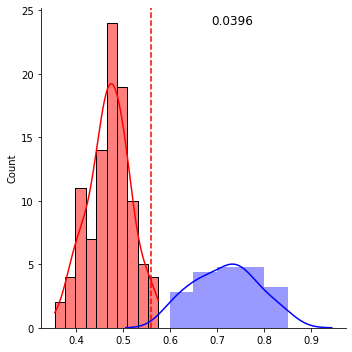

In [561]:
# permutation test
from sklearn.model_selection import permutation_test_score
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=5, scoring='accuracy', n_permutations=100, n_jobs=-1, verbose=3)

sns.displot(perm_socres, kde=True, color='red')
sns.distplot(scores['test_accuracy'], kde=True, color='blue')
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(obs_score, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
/Users/yeganeh/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


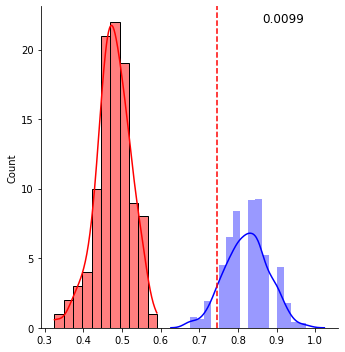

In [333]:
# permutation test
from sklearn.model_selection import permutation_test_score
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=5, scoring='accuracy', n_permutations=100, n_jobs=-1, verbose=3)

sns.displot(perm_socres, kde=True, color='red')
sns.distplot(scores['test_accuracy'], kde=True, color='blue')
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(obs_score, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

In [ ]:
# bootstrap confidence interval
np.random.choice(scores, size=1000, replace=True).mean()

## Permutation Importance
The result of my experiment:

First, I did permutation importance considering all 1770 features **(test_accuracy = 0.75)**

Using only the top five important features in my model yeilds still a significantly better performance than chance. **(test_accuracy = 0.66)**

Using the least five important feature yeilds terrible result: the distribution of scores is in quite overlap with the permuted scores. **(test_accuracy = 0.54)**

Using the top 200 important features in my model yeilds the best performance **(test_accuracy = 0.78)**

Taking all the features with positive, non-zero importance into account (n=984) won't change the model performance that much **(test_accuracy = 0.77)**

The best performance **(test_accuracy = 0.80)** , though with relatively high (=0.057) was achieved when the importance of included features were equal or higher than 0.00125.

On the contrary, when these exact features (the top 350 important features) were excluded, model's performance dropped drastically down to **0.60**

Next step was to do the permutation feature importance with the winner model: in this round, some features show a mean importance as high as 0.05, in contrast to the first round when the mean importance of the top feature was only 0.006! (This observation is definitely due to the stolen variance by those unimportant features in the first run!)

As running the permutation importance code was incredibly faster this time, we increased the number of repetation and our top feature got a mean importance of 0.08! The test accuracy this time was as high as **0.82**

Problem of **data leakage**: when I only took the experience part of the data, the accuracy fell to **0.74** with a higher std (0.09), but this result was still beat the permuted classifier! (using only half of the data did not have such a effect (acc = 0.8 on first haf, 0.78 on second half)! so lower accuracy is not because of the smaller data) interestingly, in the permutation test, p_value is 0.3 when we use only the second half of the data and 0.01 when we use the first half. P_value remains 0.0099 when we only include the experience parts.

Dropping self conncetions and connections to M1 and M2 gave as an accuracy of 0.75 and std = 0.05.

The performance of the model with the aggregate connections across different brain areas was 0.62, std = 0.07 and scores' distribution had two peaks. 

In [339]:
from sklearn.inspection import permutation_importance

importances = []
for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    pipe.fit(X.iloc[train], y.iloc[train])
    perm_imp_results = permutation_importance(
        pipe, X.iloc[test], y.iloc[test], scoring='accuracy', n_repeats=10, n_jobs=-1)
    importances.append(perm_imp_results['importances'])
# TODO change n_repeats to 10 at least!!!

100%|██████████| 500/500 [14:26<00:00,  1.73s/it]


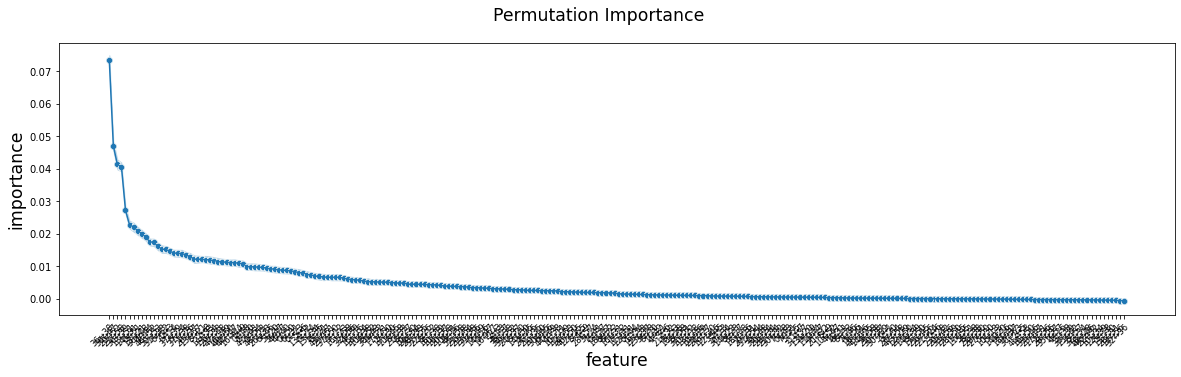

In [340]:
imp_df1 = pd.DataFrame(np.hstack(importances), index=X.columns)
imp_df1.reset_index(inplace=True)
imp_df1 = imp_df1.melt(id_vars=['index'])
imp_df1.rename(columns={'index': 'feature', 'value': 'importance', 'variable': 'repetition'}, inplace=True)
imp_df1['mean_importance'] = imp_df1.groupby('feature')['importance'].transform('mean')
imp_df1.sort_values(by='mean_importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(20, 5))
# sns.barplot(x='importance', y='feature', data=imp_df1, orient='h', ax=ax, )
sns.lineplot(x='feature', y='importance', data=imp_df1, ax=ax, ci=95)
sns.scatterplot(x='feature', y='mean_importance', data=imp_df1, ax=ax)
plt.xticks(rotation=45, fontsize='small', rotation_mode='anchor', ha='right')
plt.xlabel('feature', fontsize='xx-large')
plt.ylabel('importance', fontsize='xx-large')
plt.suptitle('Permutation Importance', fontsize='xx-large')
plt.show()

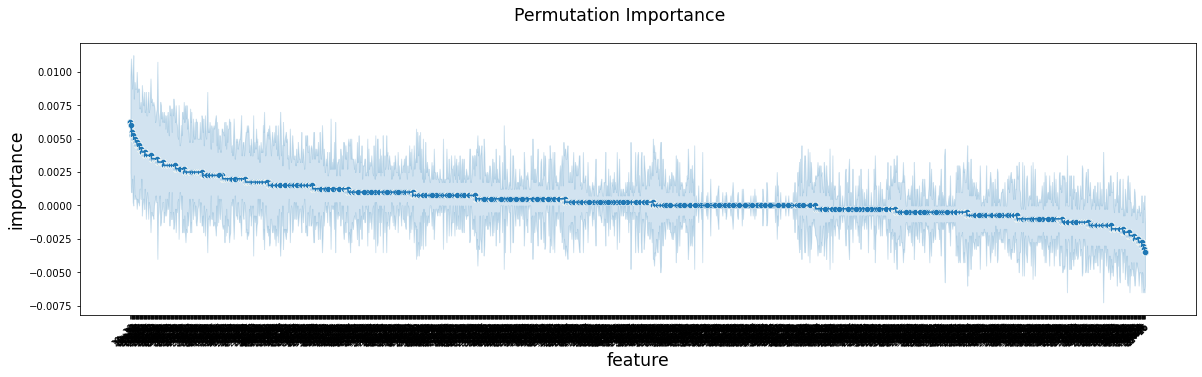

In [168]:
imp_df = pd.DataFrame(np.hstack(importances), index=X.columns)
imp_df.reset_index(inplace=True)
imp_df = imp_df.melt(id_vars=['index'])
imp_df.rename(columns={'index': 'feature', 'value': 'importance', 'variable': 'repetition'}, inplace=True)
imp_df['mean_importance'] = imp_df.groupby('feature')['importance'].transform('mean')
imp_df.sort_values(by='mean_importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(20, 5))
# sns.barplot(x='importance', y='feature', data=imp_df, orient='h', ax=ax, )
sns.lineplot(x='feature', y='importance', data=imp_df, ax=ax, ci=95)
sns.scatterplot(x='feature', y='mean_importance', data=imp_df, ax=ax)
plt.xticks(rotation=45, fontsize='small', rotation_mode='anchor', ha='right')
plt.xlabel('feature', fontsize='xx-large')
plt.ylabel('importance', fontsize='xx-large')
plt.suptitle('Permutation Importance', fontsize='xx-large')
plt.show()